In [11]:
import pandas as pd
import glob
import numpy as np
from scipy.io import loadmat
import seaborn as sns
from sklearn.linear_model import LogisticRegression

### Variable Key
- soc_win - affective feedback in a trial. 0 lose and 1 is win 
- prev_aff_fb - affective feedback in the previous trial, 0 is lose and 1 is win
- partner - 0 is nonsocial and 1  is social
- prev_partner - partner on previous trial
- point_difference - difference between the two options most recent point value

In [41]:
def set_up_data(file_path):

    df = pd.read_csv(file_path)
    
    #make previous trial partner column
    df['prev_partner'] = df.partner.shift()
    
    #make previous affective feedback column
    df['prev_aff_fb'] = df.soc_win.shift()
    
    df_list = []
    for i in dfs:
        i = i.sort_values('info_onset')
        df_list.append(i)
    
    print(df_list)
    
    known_val1 = []
    known_val2 = []

    for index, row in df.iterrows():    
        #base case- in the first trial both values are unknown
        if index == 0:
            known_val1.append(np.nan)
            known_val2.append(np.nan)
        #participant chooses option and learns value, informaiton about other option is maintained
        elif row.deckchoice == 1:
            known_val1.append(row.Npoints)
            known_val2.append(known_val2[-1])
        elif row.deckchoice == 2:
            known_val2.append(row.Npoints)
            known_val1.append(known_val1[-1])
            
        #lapsed trials contain a 11 or 22 deckchoice value are handled here as nans
        else:
            known_val1.append(np.nan)
            known_val2.append(np.nan)
            
    #get the difference between both 'known' values
    point_difference = []
    for i, j in zip(known_val1, known_val2):
        if i == np.nan or j == np.nan:
            point_difference.append(np.nan)
        else:
            point_difference.append(i - j)
    
    df['point_difference'] = point_difference  
    
    
    
    
    
    return df
set_up_data('../data/behavioral/sub-1002.csv')

[    index  Unnamed: 0  Unnamed: 0.1  Npoints  lapse1  lapse2  deckchoice  \
5     106         106            26       39       0       0          22   
7     108         108            28        0       1       0           0   
28     88          88             8       49       0       0          11   
21     81          81             1       33       0       0          22   
39     80          80             0       31       0       0           2   
22     82          82             2       30       0       0           2   
23     83          83             3       48       0       0           1   
24     84          84             4       45       0       0           1   
25     85          85             5       32       0       0           2   
26     86          86             6       36       0       0           2   
27     87          87             7       39       0       0           2   
29     89          89             9       46       0       0           1   
30     90  

,index,Unnamed: 0,Unnamed: 0.1,Npoints,lapse1,lapse2,deckchoice,RT1,RT2,choice_onset,...,stiminf,point_total,word,rating,is_catch,partner,highval_count,prev_partner,prev_aff_fb,point_difference
0,119,119,39,52,0,0,2,0.843256,1.222214,765.075343,...,0,721,irritable,0.00,0,1,19,0.0,1.0,NaN
1,102,102,22,58,0,0,1,0.524200,1.403136,431.052735,...,0,381,guilty,0.00,0,1,14,1.0,1.0,NaN
2,103,103,23,39,0,0,2,0.514482,1.763355,450.552071,...,0,420,attentive,0.00,0,0,14,1.0,1.0,19.0
3,104,104,24,41,0,0,2,0.884555,1.286292,470.051350,...,0,420,strong,0.00,0,1,14,0.0,1.0,17.0
4,105,105,25,57,0,0,1,0.307715,1.232528,490.300729,...,0,477,jittery,0.00,0,1,15,1.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,24,24,24,24,0,0,2,0.609280,0.000000,485.534183,...,1,2716,nervous,2.95,1,1,70,0.0,0.0,23.0
156,23,23,23,43,0,0,1,1.595357,0.751091,466.034717,...,1,2716,active,0.00,0,0,70,1.0,1.0,19.0
157,22,22,22,27,0,0,2,0.545922,1.324990,448.535418,...,1,2716,distressed,0.00,0,1,69,1.0,1.0,16.0
158,20,20,20,30,0,0,1,0.286775,1.517662,409.786589,...,1,2656,afraid,0.00,0,1,68,0.0,0.0,3.0


In [15]:
#logistic regression per subject

#predict outcome var: deckchoice

#regressors- point_difference, partner, prev_aff_fb 

#TO BE ADDED - interactions? partner type * N Points? 


class Subject():
    def __init__(self, subnum):
                
        self.data_path = '../data/behavioral/'   
        self.subnum = subnum 
        #self.df = pd.read_csv(self.data_path + f'sub-{self.subnum}.csv')
        
        self.df = set_up_data(self.data_path + f'sub-{self.subnum}.csv')
        
    
    #calculate beta estimates at the subject level
    def get_weights_model1(self):
        
        #subset dataframe to include variables of interest
        df_subset = self.df[['deckchoice',
                            'partner',
                            'prev_aff_fb',
                            'point_difference']]
        
        #get rid of rows with missing values
        df_subset = df_subset.dropna()
        
        #split dataframe into data and the label to be predicted
        data = df_subset.iloc[:, 1:]
        labels = df_subset.iloc[:, :1]
        X = np.array(data.values.tolist())
        #label column needs to be shaped (n_samples, )
        y = np.array(labels.values.tolist()).ravel()
        
        #fit model
        clf=LogisticRegression()
        clf.fit(X,y)
        x = clf.coef_.tolist()
        
        #pull beta values
        beta1 = x[0][0]
        beta2 = x[0][1]
        beta3 = x[0][2]
        beta_list = [beta1, beta2, beta3]
        
        return beta_list

In [19]:
df = Subject(1002).df.block
print(df)

0      4
1      4
2      4
3      4
4      4
      ..
155    2
156    2
157    2
158    2
159    2
Name: block, Length: 160, dtype: int64


In [9]:
#nest subject within Dataset class to run all subjects at once
class Dataset():
    def __init__(self, path):
        
        #read in path and generate file lsit
        self.path = path
        self.file_list = glob.glob(f'{self.path}')
        
        #get subject number list from filenames 
        self.sub_df = []
        for i in self.file_list:
            subno = int(i[-8:-4])
            self.sub_df.append(int(i[-8:-4]))
    
    #generate dataframe of beta weights for all subjects     
    def get_model1_df(self):
        #initialize dataframe object
        df = pd.DataFrame()
        #iterate over subjects and get beta weights
        for i in self.sub_df:
            df[i] = Subject(i).get_weights_model1()
        #change subject per column to subject per row
        df = df.transpose()
        
        #name columns, NOTE: NEEDS OPTIMIZATION so these are read in automatically from 'subject' class
        df.columns = ['partner',
                      'prev_aff_fb',
                      'point_difference']
        return df

       partner  prev_aff_fb  point_difference
1002 -0.155904     0.147157          0.007180
1003 -0.539216     0.070452         -0.021040
1005 -0.273140     0.759299         -0.072023
1006  0.585108    -0.098836          0.000566
1007 -0.184084     0.035551         -0.104204
1008  0.743974     0.595151         -0.040745
1009 -0.342396     0.218305         -0.099330
1010 -0.817956    -0.276572         -0.106370
1011  0.994746    -0.051709         -0.000138
1012 -0.501547     0.850277         -0.006751
1013 -0.301879     0.450152         -0.013698
1014  0.251463     0.093275         -0.032088
1015  0.239108    -0.019342         -0.017618
1016  0.440999    -0.392192         -0.089681
1017 -0.513460    -0.790533          0.005621
1018  0.138828     0.147361         -0.007206
1019 -0.262563     0.498486          0.012112
1020  0.722252     0.756625         -0.081281
1021  0.319937    -0.069186         -0.039711
1022 -0.106622    -0.362591         -0.069424
1023 -0.492315     0.304938       

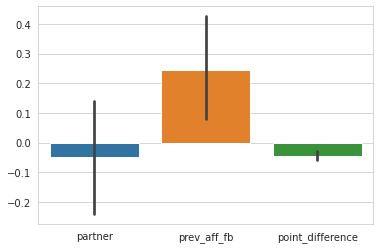

In [10]:
#run model on all subjects and plot, call dataset with regular expression
df = Dataset('../data/behavioral/sub-10*.csv').get_model1_df()
sns.set_style("whitegrid")
print(df)
ax = sns.barplot(data=df)